# Utilizing multilayer perceptrons (MLP) for rain prediction in NYC

[Previously](https://github.com/rashecl/NYC_rain_prediction), we've utilized logistic regression, k-nearest-neighbors, and random forest classifications to predict the likelihood of rain on the next day in NYC. Now we'll train a multilayer perceptron (MLP). To help us with this process we'll import all the functions that we've previously defined and load the packages we'll need for this notebook:

In [218]:
import hourlyWeatherFcns as hWF
import numpy as np
import pandas as pd
from sklearn import utils, model_selection, metrics, linear_model, neighbors, ensemble
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal, stats
from IPython.display import display
from math import ceil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical

Next, we will extract and process the NYC weather data for training the MLPs. 
In short, this involves: 

1) Extracting temporal atmoshperic condition data for NYC.<br>
2) Sliding window transformation for feature matrix, and boolean value of rain or not the next day for target.<br>
3) Preprocess data for ML:<br>
> a) Shuffling the dataset <br>
b) Allocating Train and Test sets <br>
c) Subseting the Train set into train and validation sets <br>
d) Defining k-fold cross-validation splitting method<br>
    


1) Extract temporal atmoshperic condition data for NYC:


,datetime,humidity_NewYork,wind_direction_NewYork,temperature_NewYork,pressure_NewYork,wind_speed_NewYork,rain_NewYork
0,2012-10-02 00:00:00,-0.579026,0.630695,0.356155,-0.496423,1.274213,0
1,2012-10-02 01:00:00,-0.629308,0.630695,0.363909,-0.496423,1.274213,0
2,2012-10-02 02:00:00,-0.629308,0.640003,0.371663,-0.496423,1.274213,0
3,2012-10-02 03:00:00,-0.629308,0.640003,0.379417,-0.496423,1.274213,0
4,2012-10-02 04:00:00,-0.679590,0.640003,0.387171,-0.496423,1.274213,0
...,...,...,...,...,...,...,...
44443,2017-10-27 19:00:00,-1.685229,-1.826507,0.448081,0.195462,-1.009487,0
44444,2017-10-27 20:00:00,-1.534383,-1.826507,0.448081,0.195462,-0.096007,0
44445,2017-10-27 21:00:00,-1.433819,-1.826507,0.399168,0.195462,-1.009487,0
44446,2017-10-27 22:00:00,-0.629308,-0.002220,0.246559,0.195462,-0.552747,0


2) Sliding window transformation for feature matrix, and boolean value of rain or not the next day for target:
Feature Matrix:


,humidity_NewYork_0,humidity_NewYork_1,humidity_NewYork_2,humidity_NewYork_3,humidity_NewYork_4,humidity_NewYork_5,humidity_NewYork_6,humidity_NewYork_7,humidity_NewYork_8,humidity_NewYork_9,...,rain_NewYork_14,rain_NewYork_15,rain_NewYork_16,rain_NewYork_17,rain_NewYork_18,rain_NewYork_19,rain_NewYork_20,rain_NewYork_21,rain_NewYork_22,rain_NewYork_23
0,-0.579026,-0.629308,-0.629308,-0.629308,-0.679590,-0.679590,-0.679590,-0.679590,-0.729872,-0.729872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.031563,-1.031563,-1.031563,-0.377898,-0.579026,-0.729872,-0.579026,-0.729872,-0.176770,-0.729872,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,1.331690,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.331690,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.080280,1.381972,1.683663,1.683663,1.683663,1.683663,1.683663,1.482536,1.331690,1.482536,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.080280,1.080280,1.331690,1.080280,0.828870,1.080280,1.080280,1.683663,1.381972,1.080280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,-1.383537,-1.232691,-1.081845,-0.930999,-0.729872,-0.579026,-0.930999,-0.780154,-0.780154,-0.176770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1847,-0.176770,-0.176770,-0.176770,0.275768,0.778588,0.778588,1.080280,1.080280,1.331690,1.331690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1848,0.527178,0.326050,0.577460,0.577460,0.828870,0.828870,0.828870,0.828870,0.828870,0.828870,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1849,1.331690,1.080280,1.381972,1.381972,1.381972,1.080280,1.331690,1.331690,1.331690,1.331690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3) a) Shuffle dataset, b)allocate Train and Test sets c) subset Train set into train and validation sets d) also define k-fold cross-validation splitting method
4) Show how data was split:


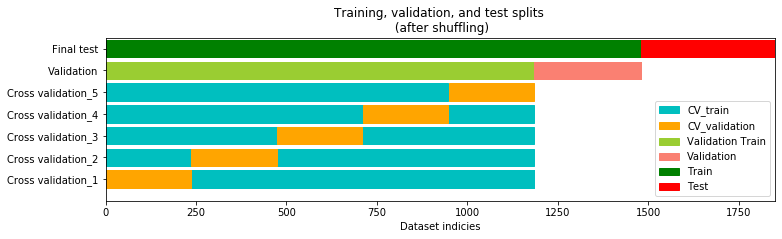

In [270]:
print("1) Extract temporal atmoshperic condition data for NYC:") 
weatherData = hWF.getWeatherData(cities = ['NewYork'])
print("2) Sliding window transformation for feature matrix, and boolean value of rain or not the next day for target:")
featureMatrix, target, featureNames = hWF.constructMLdatasets(weatherData)
print("3) a) Shuffle dataset, b)allocate Train and Test sets c) subset Train set into train and validation sets d) also define k-fold cross-validation splitting method")
X_Train, X_Test, y_Train, y_Test, X_train, X_val, y_train, y_val, cv = hWF.preprocessData(featureMatrix, target, test_size=.2, val_size =.2, n_splits=5)
print("4) Show how data was split:")
hWF.showDataSplits(y_train, y_val,y_Train, y_Test, cv)

## Train a MLP to predict if it will rain the next day

The MLP will have an 144 inputs (dimensions) that will diverge by a factor of n (i.e. nodes per dimension). We will next examine how n affects training.
The output layer will have only two nodes, one for each target class (rain and no-rain).


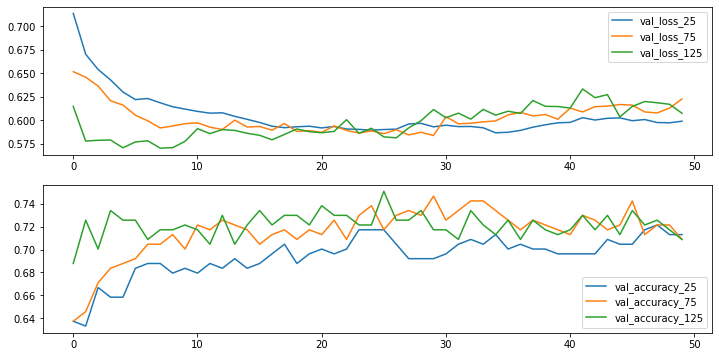

In [257]:
numFactors = X_train.shape[1]
numClasses = 2 # rain-yes rain-no
plt.subplots(figsize=(12, 6))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
for nodes in range(25,151,50):
    mdl4 = Sequential()
    mdl4.add(Dropout(0.25, input_shape=(numFactors,)))
    mdl4.add(Dense(nodes, activation='relu', input_dim=numFactors)) # An input layer is already defined
    mdl4.add(Dropout(0.25))
    # We could potentially add hidden layers here, but make them relu because that deals with vanishing gradients well. 
    mdl4.add(Dense(numClasses, activation='softmax'))
    mdl4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Alternatively: loss='mse' but that is subject to getting stuck at local minima
    mdl4History = mdl4.fit(X_train.astype('float32') , to_categorical(np.array(y_train)), 
                           epochs=50, batch_size=50, verbose=0, validation_split=0.2)
    key = 'val_loss'
    y = mdl4History.history[key];
    x = list(range(len(y)))
    ax1.plot(x,y,label = key + '_' + str(nodes))
    
    key = 'val_accuracy'
    y = mdl4History.history[key];
    x = list(range(len(y)))
    ax2.plot(x,y,label = key + '_' + str(nodes))
    

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='best')    
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='best')   
plt.show()


It seems like 75 nodes with 30 training epochs has high accuracy and low variance error, so we'll move forward with that. 

In [286]:
nodes = 75
mdl4 = Sequential()
mdl4.add(Dropout(0.25, input_shape=(numFactors,)))
mdl4.add(Dense(nodes, activation='relu', input_dim=numFactors)) # An input layer is already defined
mdl4.add(Dropout(0.25))
# We could potentially add hidden layers here, but make them relu because that deals with vanishing gradients well. 
mdl4.add(Dense(numClasses, activation='softmax'))
mdl4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Alternatively: loss='accuracy'
mdl4History = mdl4.fit(X_train.astype('float32') , to_categorical(np.array(y_train)), 
                       epochs=30, batch_size=50, verbose=0, validation_split=0.2)

print(mdl4.summary())

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_148 (Dropout)        (None, 144)               0         
_________________________________________________________________
dense_266 (Dense)            (None, 75)                10875     
_________________________________________________________________
dropout_149 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_267 (Dense)            (None, 2)                 152       
Total params: 11,027
Trainable params: 11,027
Non-trainable params: 0
_________________________________________________________________
None


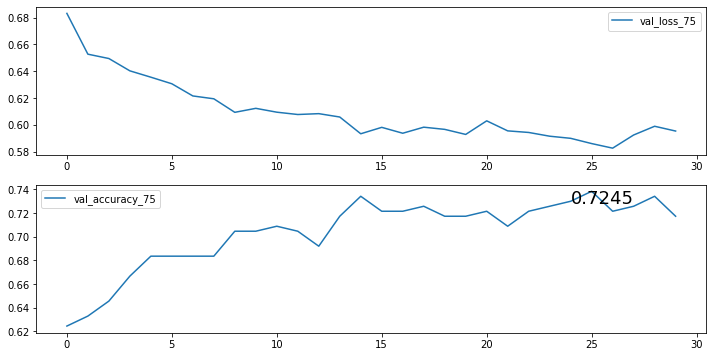

71.28378378378379

In [259]:
# Let's define a function to plot the training, and plot the model with 125 nodes: 
def plotTraining(mdlHistory, nodes = 999):
    plt.subplots(figsize=(12, 6))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)

    key = 'val_loss'
    y = mdlHistory.history[key]
    x = list(range(len(y)))
    ax1.plot(x,y,label = key + '_' + str(nodes))

    key = 'val_accuracy'
    y = mdlHistory.history[key]
    x = list(range(len(y)))
    ax2.plot(x,y,label = key + '_' + str(nodes))
    val_acc = np.mean(mdlHistory.history['val_accuracy'][-11:-1])
    plt.annotate('%.4f'% val_acc, (x[-6],val_acc),va = 'bottom', size = 18)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='best')    
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, loc='best') 
    
    plt.show()

plotTraining(mdl4History, nodes = nodes)
valAccuracy = sum(((mdl4.predict(X_val.astype('float32'))[:,1] > .5) == y_val))/len(y_val)*100
valAccuracy

Let's next see if we can get any improvement by adding a hidden layer. 

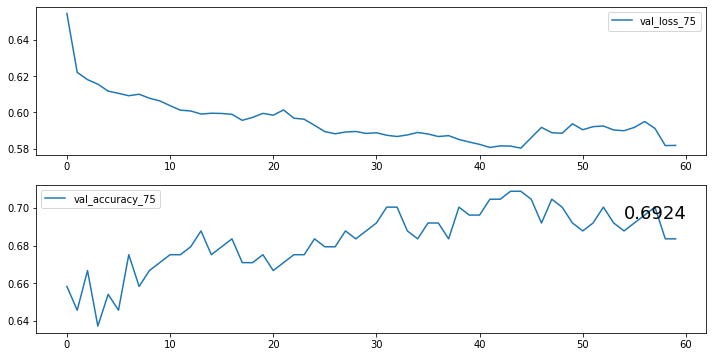

73.3108108108108

In [264]:
nodes = 75
mdl5 = Sequential()
mdl5.add(Dropout(0.25, input_shape=(numFactors,)))
mdl5.add(Dense(nodes, activation='relu', input_dim=numFactors)) # An input layer is already defined
mdl5.add(Dropout(0.50))
# Add hidden layer here:
mdl5.add(Dense(100, activation='relu'))
mdl5.add(Dropout(0.50))
mdl5.add(Dense(numClasses, activation='softmax'))
mdl5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Alternatively: loss='accuracy'
mdl5History = mdl5.fit(X_train.astype('float32') , to_categorical(np.array(y_train)), 
                           epochs=60, batch_size=50, verbose=0, validation_split=0.2)
plotTraining(mdl5History, nodes = nodes)
valAccuracy = sum(((mdl5.predict(X_val.astype('float32'))[:,1] > .5) == y_val))/len(y_val)*100
valAccuracy

Having two hidden layers may have helped. <br>

Lastly, we can see how the MLPs compare to the previous models on the Test set.

Accuracy of previous classifiers on TEST set: <br> 
___________________
BaselineMdl : 70.61995% <br>
KNN : 66.84636% <br>
Random forest : 72.77628% <br>
Random forest with feature engineering : 72.23720% <br>

In [287]:
# Fit the models to the Training data
mdl4.fit(X_Train.astype('float32') , to_categorical(np.array(y_Train)), 
                           epochs=30, batch_size=50, verbose=0, validation_split=0.2)
mdl5.fit(X_Train.astype('float32') , to_categorical(np.array(y_Train)), 
                           epochs=60, batch_size=50, verbose=0, validation_split=0.2)

In [288]:
acc4= sum(((mdl4.predict(X_Test.astype('float32'))[:,1] > .5) == y_Test))/len(y_Test)*100
acc5= sum(((mdl5.predict(X_Test.astype('float32'))[:,1] > .5) == y_Test))/len(y_Test)*100

print('Accuracy of MLP on TEST set \n------------------------------')
print('MLP_1_hiddenLayer : %.5f' %acc4 +'%')
print('MLP_2_hiddenLayers : %.5f' %acc5 +'%')


Accuracy of MLP on TEST set 
------------------------------
MLP_1_hiddenLayer : 70.61995%
MLP_2_hiddenLayers : 68.73315%


Moving forward, we can determine a principled way to improve the accuracy in these neural networks, but this tutorial just focused on the first step of creating MLPs to make predictions.